In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
#from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

print("done")

done


In [2]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

def clean_up_gender_data(gender):
  gender = np.asarray(gender)
  gender[np.where(gender == "Male")] = 0
  gender[np.where(gender == "male")] = 0
  gender[np.where(gender == "M")] = 0
  gender[np.where(gender == "Female")] = 1
  gender[np.where(gender == "female")] = 1
  gender[np.where(gender == "F")] = 1
  gender[np.where(gender == "NaN")] = 2
  np.unique(gender)
  gender = gender.astype(np.int)
  return gender

def clean_up_age_data(age):
    age = np.asarray(age)
    age[np.where(age == "NaN")] = -1
    np.unique(age)
    age = age.astype(np.int)
    return age

def import_gender_and_age(age, gender):
    gender_binary = clean_up_gender_data(gender)
    age_clean = clean_up_age_data(age)
    print("gender data shape: {}".format(gender_binary.shape[0]))
    print("age data shape: {}".format(age_clean.shape[0]))
    return age_clean, gender_binary

def import_key_data(path):
    gender=[]
    age=[]
    labels=[]
    ecg_filenames=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                labels.append(header_data[15][5:-1])
                ecg_filenames.append(filepath)
                gender.append(header_data[14][6:-1])
                age.append(header_data[13][6:-1])
    return gender, age, labels, ecg_filenames

def get_signal_lengths(path, title):
    signal_lenght=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                splitted = header_data[0].split()
                signal_lenght.append(splitted[3])
    signal_lenght_df = pd.DataFrame(signal_lenght)
    signal_count=signal_lenght_df[0].value_counts()
    plt.figure(figsize=(20,10))
    plt.title(title,fontsize =36)
    sns.barplot(signal_count[:10,].index, signal_count[:10,].values)
      #plt.savefig("signallengde.png")
        
def make_undefined_class(labels, df_unscored):
    df_labels = pd.DataFrame(labels)
    for i in range(len(df_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(df_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)

    '''
    #equivalent classes
    codes_to_replace=['713427006','284470004','427172004']
    replace_with = ['59118001','63593006','17338001']

    for i in range(len(codes_to_replace)):
        df_labels.replace(to_replace=codes_to_replace[i], inplace=True ,value=replace_with[i], regex=True)
    '''
    return df_labels


def onehot_encode(df_labels):
    one_hot = MultiLabelBinarizer()
    y=one_hot.fit_transform(df_labels[0].str.split(pat=','))
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)
    y = np.delete(y, -1, axis=1)
    print("classes: {}".format(y.shape[1]))
    return y, one_hot.classes_[0:-1]


def plot_classes(classes, scored_classes,y):
    for j in range(len(classes)):
        for i in range(len(scored_classes.iloc[:,1])):
            if (str(scored_classes.iloc[:,1][i]) == classes[j]):
                classes[j] = scored_classes.iloc[:,0][i]
    plt.figure(figsize=(30,20))
    plt.bar(x=classes,height=y.sum(axis=0))
    plt.title("Distribution of Diagnosis", color = "black", fontsize = 30)
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnosis", color = "black")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize = 20)
    plt.savefig("fordeling.png")
    plt.show()


def get_labels_for_all_combinations(y):
    y_all_combinations = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_all_combinations

def split_data(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds

def plot_all_folds(folds,y,onehot_enc):
    X_axis_labels=onehot_enc
    plt.figure(figsize=(20,100))
    h=1
    for i in range(len(folds)):
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        h=h+1
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        h=h+1
        
def get_val_data(validation_filename):
    ecg_val_timeseries=[]
    for names in validation_filename:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_val_timeseries.append(data)
    ecg_val_timeseries = np.asarray(ecg_val_timeseries)
    return ecg_val_timeseries

def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

def generate_validation_data_with_demo_data(ecg_filenames, y, gender, age, test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_val = np.asarray(ecg_train_timeseries)

    X_val = X_val.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)
    
    age_val = age[test_order_array]
    
    gender_val = gender[test_order_array]
    
    demograpics_val_data = np.column_stack((age_val, gender_val))
    X_combined_val = [X_val, demograpics_val_data]

    return X_combined_val, y_train_gridsearch


            
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights


def residual_network_1d():
    n_feature_maps = 64
    input_shape = (5000,12)
    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(27, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def encoder_model():
    input_layer = keras.layers.Input(shape=(5000, 12))


     # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(units=27,activation='sigmoid')(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def FCN():
    inputlayer = keras.layers.Input(shape=(5000,12)) 

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)


    outputlayer = keras.layers.Dense(27, activation='sigmoid')(gap_layer)

    model = keras.Model(inputs=inputlayer, outputs=outputlayer)
  


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def residual_network_1d_demo():
    n_feature_maps = 64
    input_shape = (5000,12)
    inputA = keras.layers.Input(input_shape)
    inputB = keras.layers.Input(shape=(2,))

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(inputA)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(inputA)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(27, activation='softmax')(gap_layer)

    mod1 = keras.models.Model(inputs=inputA, outputs=output_layer)
    

    mod2 = keras.layers.Dense(50, activation="relu")(inputB) 
    mod2 = keras.layers.Dense(2, activation="sigmoid")(mod2) 
    mod2 = keras.models.Model(inputs=inputB, outputs=mod2)

    combined = keras.layers.concatenate([mod1.output, mod2.output])

    z = keras.layers.Dense(27, activation="sigmoid")(combined)

    model = keras.models.Model(inputs=[mod1.input, mod2.input], outputs=z)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def encoder_model_demo():
    inputA = keras.layers.Input(shape=(5000, 12))
    inputB = keras.layers.Input(shape=(2,))
    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer


    output_layer = keras.layers.Flatten()(dense_layer)  

    mod1 = keras.Model(inputs=inputA, outputs=output_layer)

    mod2 = keras.layers.Dense(50, activation="relu")(inputB) 
    mod2 = keras.layers.Dense(2, activation="sigmoid")(mod2) 
    mod2 = keras.models.Model(inputs=inputB, outputs=mod2)

    combined = keras.layers.concatenate([mod1.output, mod2.output])

    z = keras.layers.Dense(27, activation="sigmoid")(combined)

    model = keras.models.Model(inputs=[mod1.input, mod2.input], outputs=z)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

def FCN_demo():

    inputA = keras.layers.Input(shape=(5000,12))
    inputB = keras.layers.Input(shape=(2,))
  
  
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)



    mod3 = keras.layers.Dense(50, activation="relu")(inputB) 
    mod3 = keras.layers.Dense(2, activation="sigmoid")(mod3) 
    model3 = keras.Model(inputs=inputB, outputs=mod3)

    combined = keras.layers.concatenate([model1.output, model3.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=[inputA,inputB], outputs=final_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])
    return model

def FCN_Encoder():

    inputA = tf.keras.layers.Input(shape=(5000,12))

  
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)

    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    model2 = keras.Model(inputs=inputA, outputs=flatten_layer)

    combined = keras.layers.concatenate([model1.output, model2.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=inputA, outputs=final_layer)



    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

def FCN_Encoder_demo():

    inputA = keras.layers.Input(shape=(5000,12))
    inputB = keras.layers.Input(shape=(2,))


    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)

    conv1 = keras.layers.Conv1D(filters=256,kernel_size=10,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=512,kernel_size=22,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=1024,kernel_size=42,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:512])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,512:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=512,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    model2 = keras.Model(inputs=inputA, outputs=flatten_layer)


    mod3 = keras.layers.Dense(50, activation="relu")(inputB) # 2 -> 100
    mod3 = keras.layers.Dense(2, activation="sigmoid")(mod3) # Added this layer
    model3 = keras.Model(inputs=inputB, outputs=mod3)

    combined = keras.layers.concatenate([model1.output, model2.output, model3.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=[inputA,inputB], outputs=final_layer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
            name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve="ROC",
            summation_method="interpolation",
            name="AUC",
            dtype=None,
            thresholds=None,
            multi_label=True,
            label_weights=None,
        )])
    return model


def compute_challenge_metric_for_opt(labels, outputs):
    classes=['10370003','111975006','164889003','164890007','164909002','164917005','164934002','164947007','17338001',
 '251146004','270492004','284470004','39732003','426177001','426627000','426783006','427084000','427172004','427393009','445118002','47665007','59118001',
 '59931005','63593006','698252002','713426002','713427006']

    '''
    24 classes
    ['10370003', '111975006', '164889003', '164890007', '164909002', '164917005',
      '164934002', '164947007', '17338001', '251146004', '270492004', '39732003',
      '426177001', '426627000', '426783006' ,'427084000' ,'427393009', '445118002',
      '47665007' ,'59118001', '59931005', '63593006', '698252002', '713426002']

    
      
    '''

    normal_class = '426783006'
    weights = np.array([[1.    , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        0.5   , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 0.5   , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.425 , 1.    , 0.45  , 0.45  , 0.475 , 0.35  , 0.45  , 0.35  ,
        0.425 , 0.475 , 0.35  , 0.3875, 0.4   , 0.35  , 0.35  , 0.3   ,
        0.425 , 0.425 , 0.35  , 0.4   , 0.4   , 0.45  , 0.45  , 0.3875,
        0.4   , 0.35  , 0.45  ],
       [0.375 , 0.45  , 1.    , 0.5   , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.375 , 0.45  , 0.5   , 1.    , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.4   , 0.475 , 0.475 , 0.475 , 1.    , 0.375 , 0.475 , 0.325 ,
        0.4   , 0.45  , 0.325 , 0.3625, 0.375 , 0.325 , 0.325 , 0.275 ,
        0.4   , 0.4   , 0.325 , 0.375 , 0.375 , 0.425 , 0.475 , 0.3625,
        0.375 , 0.325 , 0.425 ],
       [0.275 , 0.35  , 0.4   , 0.4   , 0.375 , 1.    , 0.4   , 0.2   ,
        0.275 , 0.325 , 0.2   , 0.2375, 0.25  , 0.2   , 0.2   , 0.15  ,
        0.275 , 0.275 , 0.2   , 0.25  , 0.25  , 0.3   , 0.4   , 0.2375,
        0.25  , 0.2   , 0.3   ],
       [0.375 , 0.45  , 0.5   , 0.5   , 0.475 , 0.4   , 1.    , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 1.    ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        1.    , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 1.    , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.45  , 0.475 , 0.425 , 0.425 , 0.45  , 0.325 , 0.425 , 0.375 ,
        0.45  , 1.    , 0.375 , 0.4125, 0.425 , 0.375 , 0.375 , 0.325 ,
        0.45  , 0.45  , 0.375 , 0.425 , 0.425 , 0.475 , 0.425 , 0.4125,
        0.425 , 0.375 , 0.475 ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 1.    , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.4625, 0.3875, 0.3375, 0.3375, 0.3625, 0.2375, 0.3375, 0.4625,
        0.4625, 0.4125, 0.4625, 1.    , 0.4875, 0.4625, 0.4625, 0.4125,
        0.4625, 0.4625, 0.4625, 0.4875, 0.4875, 0.4375, 0.3375, 1.    ,
        0.4875, 0.4625, 0.4375],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 1.    , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 0.5   , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 1.    , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 1.    , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.375 , 0.3   , 0.25  , 0.25  , 0.275 , 0.15  , 0.25  , 0.45  ,
        0.375 , 0.325 , 0.45  , 0.4125, 0.4   , 0.45  , 0.45  , 1.    ,
        0.375 , 0.375 , 0.45  , 0.4   , 0.4   , 0.35  , 0.25  , 0.4125,
        0.4   , 0.45  , 0.35  ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        0.5   , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        1.    , 0.5   , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        1.    , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 1.    , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 1.    , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 1.    , 0.5   , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 1.    , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.475 , 0.45  , 0.4   , 0.4   , 0.425 , 0.3   , 0.4   , 0.4   ,
        0.475 , 0.475 , 0.4   , 0.4375, 0.45  , 0.4   , 0.4   , 0.35  ,
        0.475 , 0.475 , 0.4   , 0.45  , 0.45  , 1.    , 0.4   , 0.4375,
        0.45  , 0.4   , 1.    ],
       [0.375 , 0.45  , 0.5   , 0.5   , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 1.    , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.4625, 0.3875, 0.3375, 0.3375, 0.3625, 0.2375, 0.3375, 0.4625,
        0.4625, 0.4125, 0.4625, 1.    , 0.4875, 0.4625, 0.4625, 0.4125,
        0.4625, 0.4625, 0.4625, 0.4875, 0.4875, 0.4375, 0.3375, 1.    ,
        0.4875, 0.4625, 0.4375],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 0.5   , 0.45  , 0.35  , 0.4875,
        1.    , 0.45  , 0.45  ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 1.    , 0.4   ],
       [0.475 , 0.45  , 0.4   , 0.4   , 0.425 , 0.3   , 0.4   , 0.4   ,
        0.475 , 0.475 , 0.4   , 0.4375, 0.45  , 0.4   , 0.4   , 0.35  ,
        0.475 , 0.475 , 0.4   , 0.45  , 0.45  , 1.    , 0.4   , 0.4375,
        0.45  , 0.4   , 1.    ]])
    
    num_recordings, num_classes = np.shape(labels)
    normal_index = classes.index(normal_class)

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the normal class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)
    inactive_outputs[:, normal_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = float('nan')

    return normalized_score

def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

def iterate_threshold(y_pred, ecg_filenames, y ,val_fold ):
    init_thresholds = np.arange(0,1,0.05)
    
    all_scores = []
    for i in init_thresholds:
        pred_output = y_pred > i
        pred_output = pred_output * 1
        score = compute_challenge_metric_for_opt(generate_validation_data(ecg_filenames,y,val_fold)[1],pred_output)
        print(score)
        all_scores.append(score)
    all_scores = np.asarray(all_scores)
    
    return all_scores


    
    
    
def plot_normalized_conf_matrix(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses, snomedabbr):
    conf_m = compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1)
    conf_m = np.nan_to_num(conf_m)
    #min_max_scaler = preprocessing.MinMaxScaler()
    #conf_m_scaled = min_max_scaler.fit_transform(conf_m)
    normalizer = preprocessing.Normalizer(norm="l1")
    conf_m_scaled = normalizer.fit_transform(conf_m)
    df_norm_col = pd.DataFrame(conf_m_scaled)
    df_norm_col.columns = snomedabbr
    df_norm_col.index = snomedabbr
    df_norm_col.index.name = 'Actual'
    df_norm_col.columns.name = 'Predicted'
    #df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (12,10))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_norm_col, cmap="rocket_r", annot=True,cbar=False, annot_kws={"size": 10},fmt=".2f")# 
#############################
#Adding rule-based algorithms
#############################

def DetectRWithPanTompkins (signal, signal_freq):
    '''signal=ECG signal (type=np.array), signal_freq=sample frequenzy'''
    lowcut = 5.0
    highcut = 15.0
    filter_order = 2
    
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, signal)
    
    diff_y=np.ediff1d(y)
    squared_diff_y=diff_y**2
    
    integrated_squared_diff_y =np.convolve(squared_diff_y,np.ones(5))
    
    normalized = (integrated_squared_diff_y-min(integrated_squared_diff_y))/(max(integrated_squared_diff_y)-min(integrated_squared_diff_y))

    peaks, metadata = find_peaks(normalized, 
                             distance=signal_freq/5 , 
                             #height=500,
                             height=0.5,
                             width=0.5
                            )

    return peaks

def heartrate(r_time, sampfreq):
    
    #qrs = xqrs.qrs_inds from annotateR()
    #sampfreq = sample frequency - can be found with y['fs'] (from getDataFromPhysionet())
    
    HeartRate = []
    TimeBetweenBeat= []
    for index, item in enumerate(r_time,-1):
        HeartRate.append(60/((r_time[index+1]-r_time[index])/sampfreq))
        TimeBetweenBeat.append((r_time[index+1]-r_time[index])/sampfreq)
    del HeartRate[0]
    avgHr = sum(HeartRate)/len(HeartRate)
    TimeBetweenBeat= np.asarray(TimeBetweenBeat)
    TimeBetweenBeat=TimeBetweenBeat * 1000 # sec to ms
    TimeBetweenBeat = TimeBetweenBeat[1:] # remove first element
    return TimeBetweenBeat, avgHr

def R_correction(signal, peaks):
    '''signal = ECG signal, peaks = uncorrected R peaks'''
    peaks_corrected, metadata = find_peaks(signal, distance=min(np.diff(peaks)))            
    return peaks_corrected

def rule_based_predictions(ecgfilenames, val_data, dnn_prediction):
    for i in range(len(val_data)):
        data , header_data = load_challenge_data(ecgfilenames[val_data[i]])

        avg_hr = 0
        peaks = 0
        rmssd = 0
        qrs_voltage = 0
        try:
            peaks = DetectRWithPanTompkins(data[1],int(header_data[0].split()[2]))

            try:
                peaks = R_correction(data[1], peaks)
            except:
                print("Did not manage to do R_correction")

        except:
            print("Did not manage to find any peaks using Pan Tomkins")


        try:
            rr_interval, avg_hr = heartrate(peaks,int(header_data[0].split()[2]))
            try:
                rmssd = np.mean(np.square(np.diff(rr_interval)))
            except:
                print("did not manage to comp rmssd")
        except:
            print("not able to calculate heart rate")
            rr_interval = 0
            avg_hr = 0

        try:
            qrs_voltage = np.mean(data[1][peaks])
        except:
            print("Could not calculate mean QRS peak voltage")

        if avg_hr != 0:     # bare gjør disse endringene dersom vi klarer å beregne puls
            if 60 < avg_hr < 100:
                dnn_prediction[i][16] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif avg_hr < 60 & dnn_prediction[i][15] == 1:
                dnn_prediction[i][13] = 1
            elif avg_hr < 60 & dnn_prediction[i][15] == 0:
                dnn_prediction[i][14] = 1
            elif avg_hr > 100:
                dnn_prediction[i][16] = 1

        if qrs_voltage != 0:
            if qrs_voltage < 500:
                dnn_prediction[i][9] = 1
                dnn_prediction[i][15] = 0
            else:
                dnn_prediction[i][9] = 0
        else:
            dnn_prediction[i][9] = 0

        if rmssd != 0:
            if rmssd < 15:
                dnn_prediction[i][0] = 1
                dnn_prediction[i][16] = 0
                dnn_prediction[i][15] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif 2000 < rmssd < 5000:
                dnn_prediction[i][18] = 1
            elif 15000 < rmssd < 50000:
                dnn_prediction[i][2] = 1
            else:
                dnn_prediction[i][15] = 1
    return dnn_prediction

def plot_normalized_conf_matrix_rule(y_true,val_data,rb_pred,snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(y_true[val_data],rb_pred), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size


##### This was acquired from the Utility file from the same link as the Dataset

In [3]:
gender, age, labels, ecg_filenames = import_key_data("/kaggle/input/")

In [4]:
ecg_filenames = np.asarray(ecg_filenames)

In [5]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = make_undefined_class(labels,SNOMED_unscored)

In [6]:
y , snomed_classes = onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


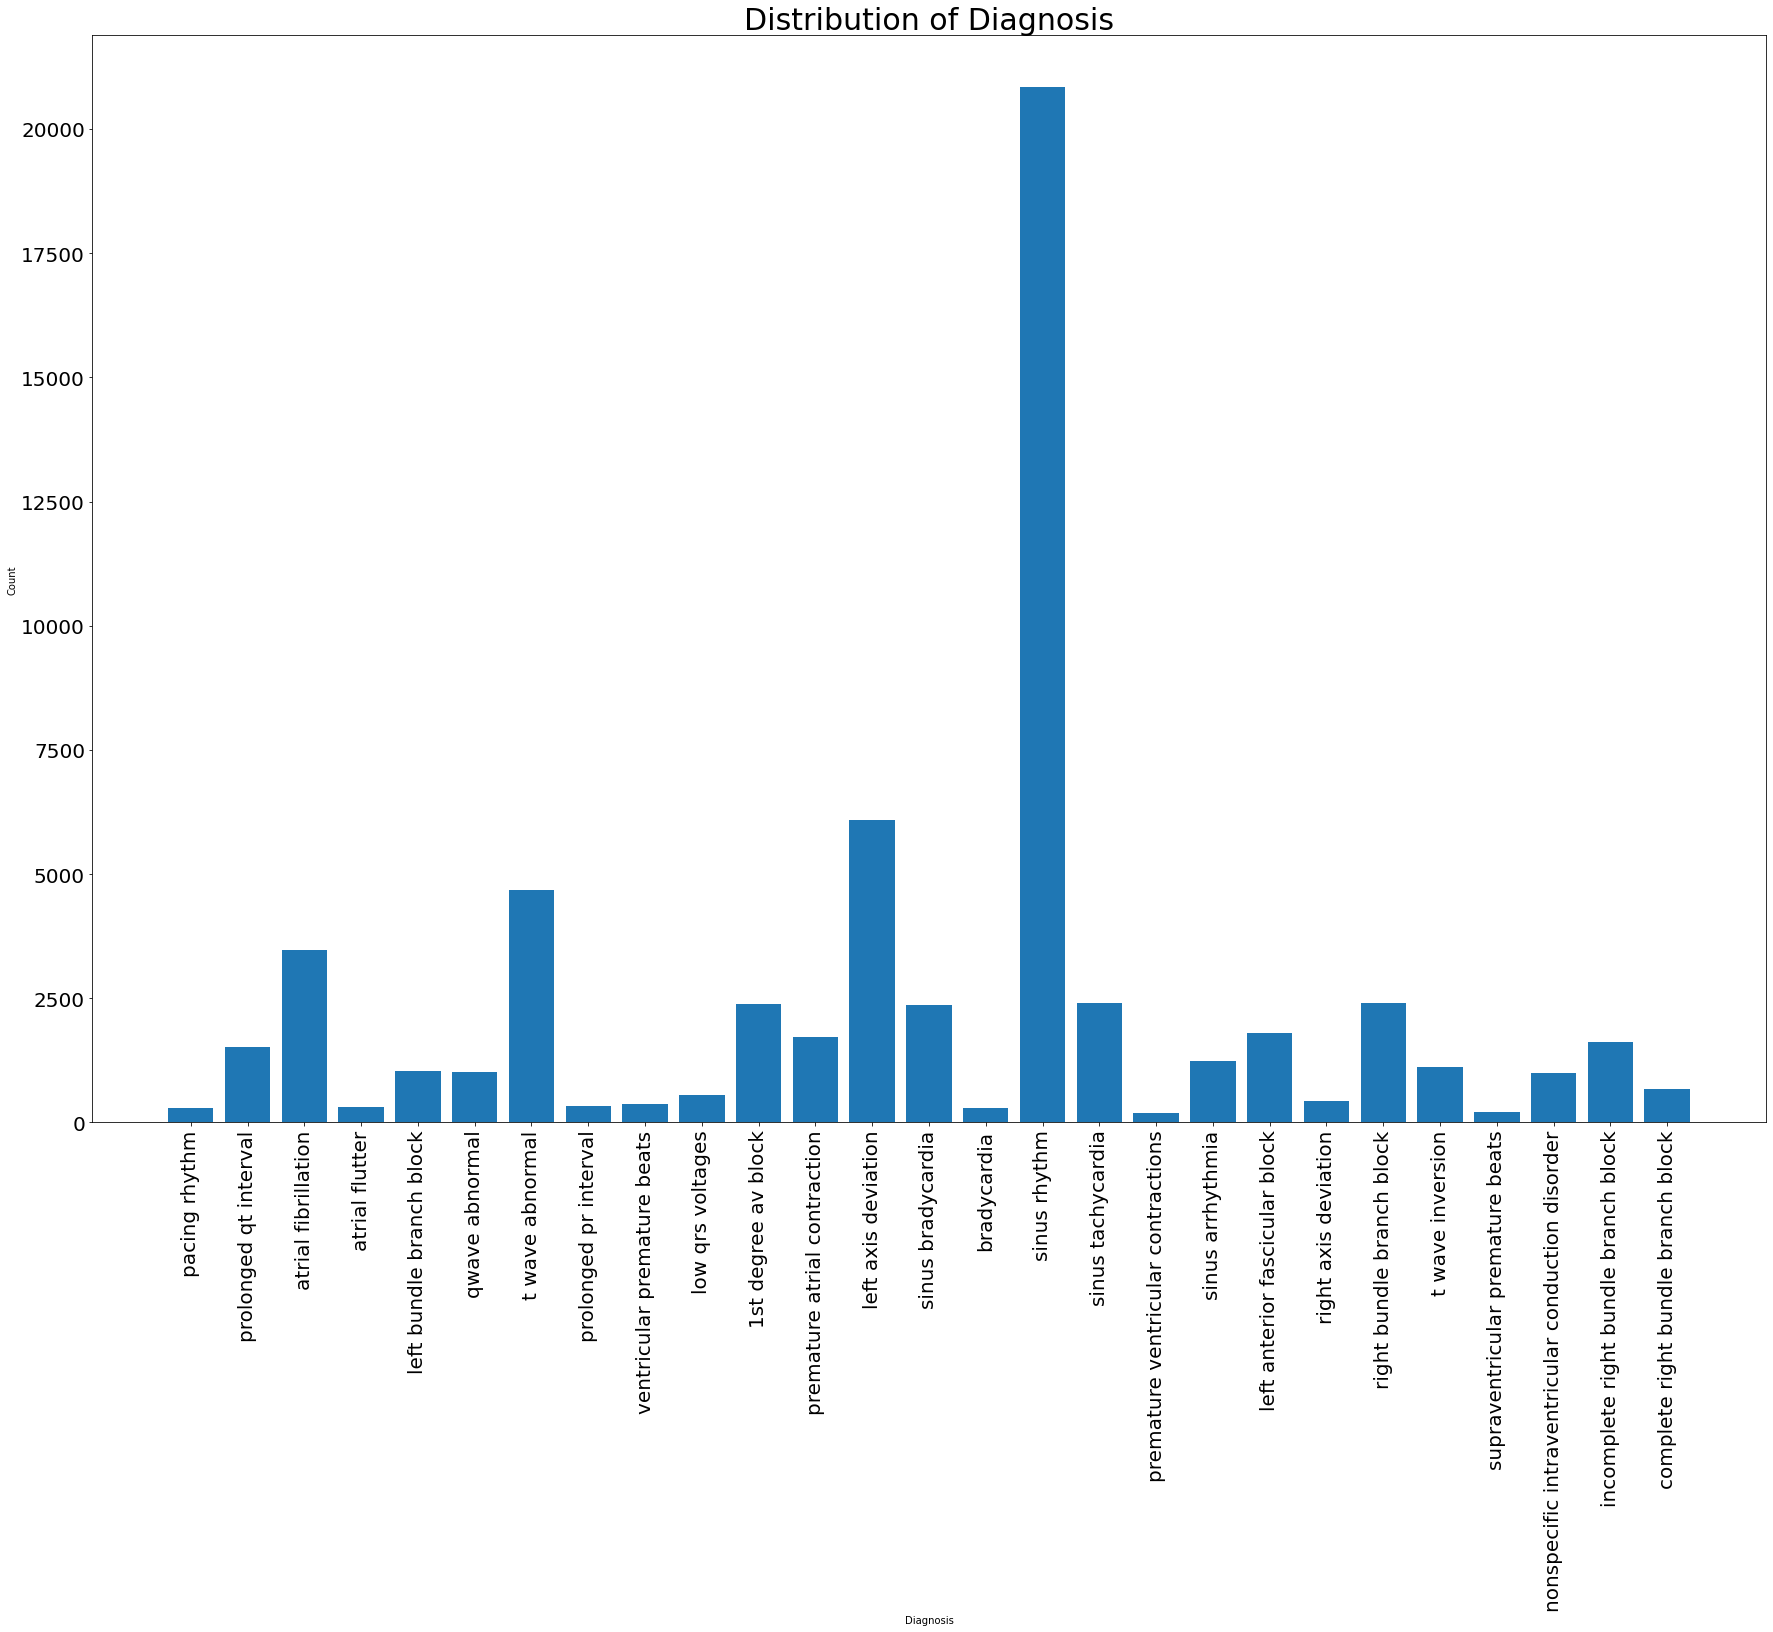

In [7]:
plot_classes(snomed_classes, SNOMED_scored,y)

In [ ]:
y_all_comb = get_labels_for_all_combinations(y)

In [10]:
folds = split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [14]:
order_array = folds[0][0]

In [15]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [17]:
def thr_chall_metrics(thr, label, output_prob):
    return -compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [18]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [19]:
def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

In [20]:
def compute_modified_confusion_matrix(labels, outputs):
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

In [21]:
def plot_normalized_conf_matrix_dev(y_pred, ecg_filenames, y, val_fold, threshold, snomedclasses):
    df_cm = pd.DataFrame(compute_modified_confusion_matrix(generate_validation_data(ecg_filenames,y,val_fold)[1], (y_pred>threshold)*1), columns=snomedclasses, index = snomedclasses)
    df_cm = df_cm.fillna(0)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    df_norm_col=(df_cm-df_cm.mean())/df_cm.std()
    plt.figure(figsize = (36,14))
    sns.set(font_scale=1.4)
    sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 16},fmt=".2f",cbar=False)# font size